In [1]:
import pandas as pd

# Data analysis

In [2]:
df = pd.read_csv("./data/SeoulBikeData.csv", encoding='unicode_escape')
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [4]:
df.isnull().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [5]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

<Axes: xlabel='Temperature(°C)', ylabel='Rented Bike Count'>

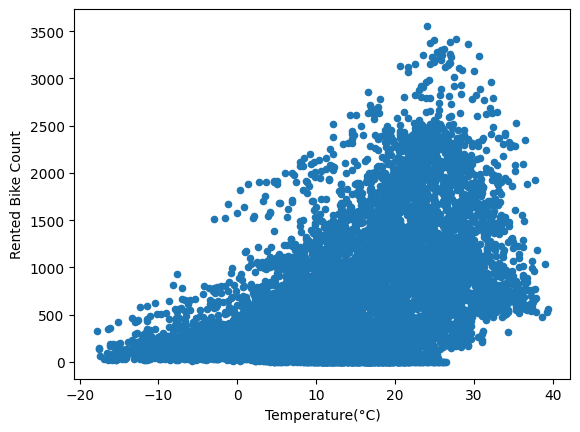

In [6]:
df[['Temperature(°C)', 'Rented Bike Count']].plot(x='Temperature(°C)', y='Rented Bike Count', kind='scatter')

As expected the demand is low when the temperature is low. Also the demand goes down when the temperature is too high.

<Axes: xlabel='Seasons', ylabel='Rented Bike Count'>

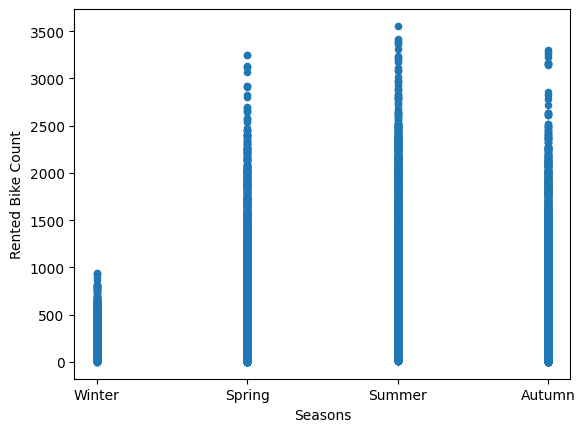

In [7]:
df[['Seasons', 'Rented Bike Count']].plot(x='Seasons', y='Rented Bike Count', kind='scatter')

<Axes: xlabel='Seasons'>

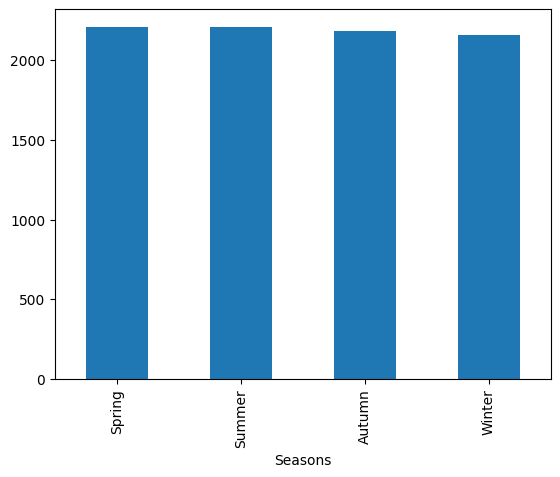

In [8]:
df['Seasons'].value_counts().plot(kind='bar')

Balanced distribution over seasons.

<Axes: xlabel='Hour', ylabel='Rented Bike Count'>

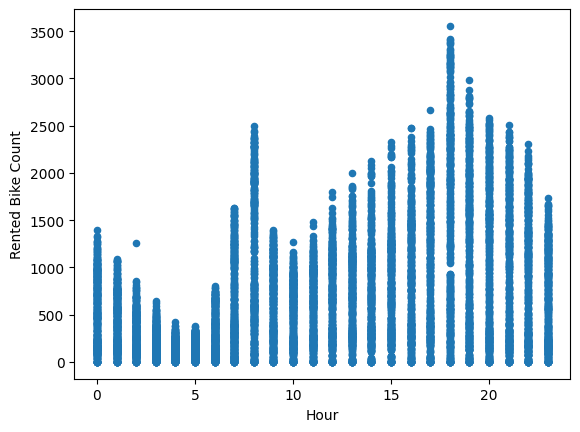

In [9]:
df[['Hour', 'Rented Bike Count']].plot(kind="scatter", x="Hour",y="Rented Bike Count")

Demand peaks in the morning and in the evening during commute hours.

<Axes: xlabel='Hour'>

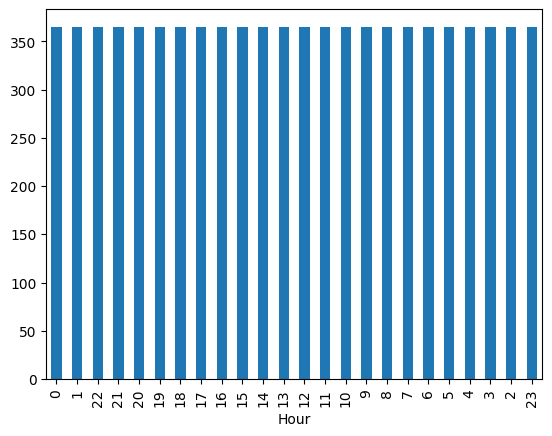

In [23]:
df['Hour'].value_counts().plot(kind="bar")

Balanced distribution over hours

<Axes: xlabel='Holiday', ylabel='Rented Bike Count'>

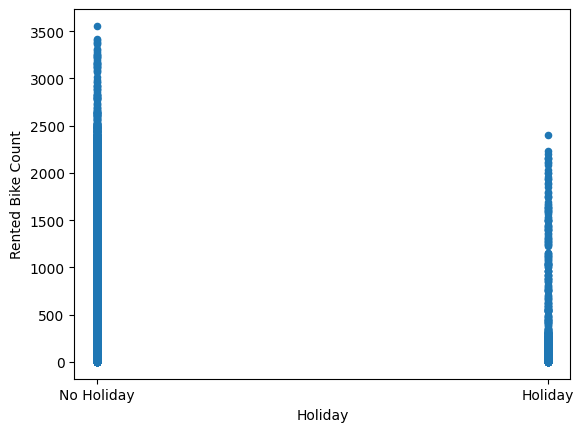

In [11]:
df[['Rented Bike Count', 'Holiday']].plot(kind="scatter", x="Holiday",y="Rented Bike Count")

Demand is higher on work days, which might be counterintuitive

<Axes: xlabel='Holiday'>

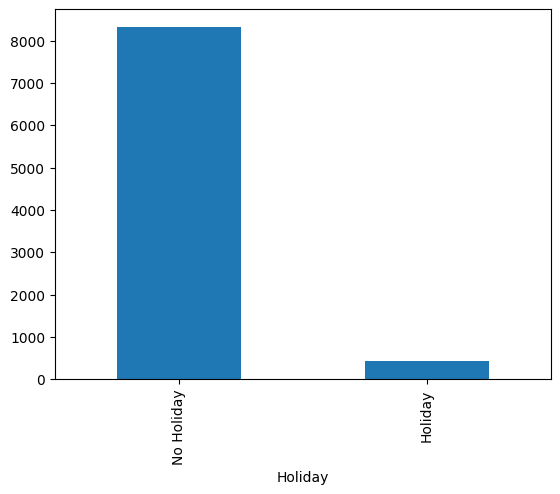

In [12]:
df['Holiday'].value_counts().plot(kind="bar")

<Axes: xlabel='Snowfall (cm)', ylabel='Rented Bike Count'>

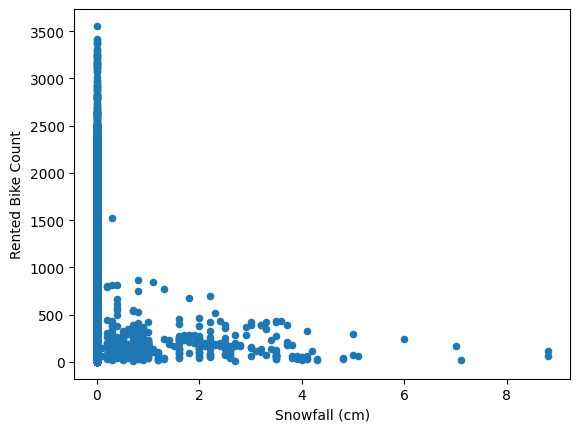

In [13]:
df[['Rented Bike Count', 'Snowfall (cm)']].plot(x='Snowfall (cm)', y='Rented Bike Count', kind="scatter")

<Axes: xlabel='Rainfall(mm)', ylabel='Rented Bike Count'>

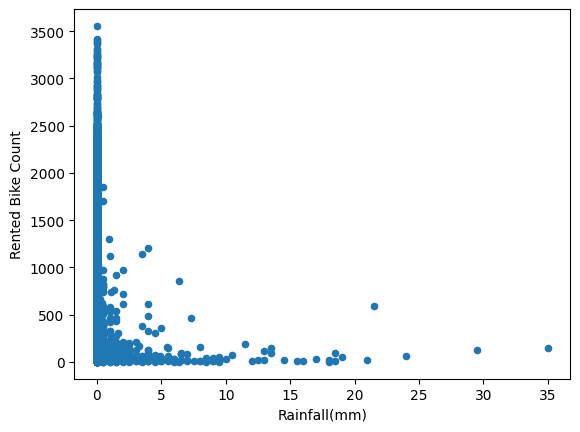

In [14]:
df[['Rented Bike Count', 'Rainfall(mm)']].plot(x='Rainfall(mm)', y='Rented Bike Count', kind="scatter")

In [15]:
season2nb = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}
nb2season = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Autumn'}
df['Seasons'] = df['Seasons'].map(season2nb)
holiday2nb = {'No Holiday': 0, 'Holiday': 1}
nb2holiday = {0: 'No Holiday', 1: 'Holiday'}
df['Holiday'] = df['Holiday'].map(holiday2nb)
funcday2nb = {'No': 0, 'Yes': 1}
nb2funcday = {0: 'No', 1: 'Yes'}
df['Functioning Day'] = df['Functioning Day'].map(funcday2nb)
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,1
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,1
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,1
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,1
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,1


In [17]:
mask = df['Functioning Day'] == 0
cleaned = df.drop(df[mask].index)
cleaned.shape

(8465, 14)